## Setup

In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggalluvial)
    library(dplyr)
    library(RColorBrewer)
    library(gridExtra)
    library(rlang)
    library(tidyr)
    library(patchwork)
    library(data.table)
    library(ggpubr)
})

home <- "/home/workspace/"
path <- "pbmc_flow/data/NDMM PB1 data - Statistics(in).csv"
util <- "pbmc_flow/utils.R"

source(file.path(home, util))

df <- fread(file.path(home, path))
df <- df[df$percentOf == "Viable cells", ]
df$subject <- df$Subject
df$visit <- df$Visit
df$cell <- df$population

timepoint_labels <- c(
    "Flu Year 1 Stand-Alone" = "Y1 SA",
    "Flu Year 1 Day 0" = "Y1 Day 0", 
    "Flu Year 1 Day 7" = "Y1 Day 7",
    "Flu Year 1 Day 90" = "Y1 Day 90",
    "Flu Year 2 Stand-Alone" = "Y2 SA",
    "Flu Year 2 Day 0" = "Y2 Day 0",
    "Flu Year 2 Day 7" = "Y2 Day 7", 
    "Flu Year 2 Day 90" = "Y2 Day 90"
)

df <- df[df$visit %in% names(timepoint_labels)]

## Data QC

### Unusual timepoint labels

In [2]:
data <- read.csv(file.path(home, path))
unique_visits <- unique(data$Visit)
visits_not_in_labels <- unique_visits[!unique_visits %in% names(timepoint_labels)]
print(visits_not_in_labels)

[1] "Flu Year 1 Stand-Alone/MM Post Transplant 90 Days" 
[2] "Flu Year 2 Day 90/MM Post Transplant 1 year"       
[3] "Flu Year 1 Day 90/MM Post Transplant 1 year"       
[4] "Flu Year 1 Stand-Alone/ MM Post Transplant 90 Days"
[5] "Flu Year 2 Stand-AloneN/A - stand-alone collection"
[6] "Flu Year 2 Day 90MM Post Transplant 2 year"        
[7] "Flu Year 1 Day 7MM Post Transplant 90 Days"        


### Sample Availability by Subject and Timepoint

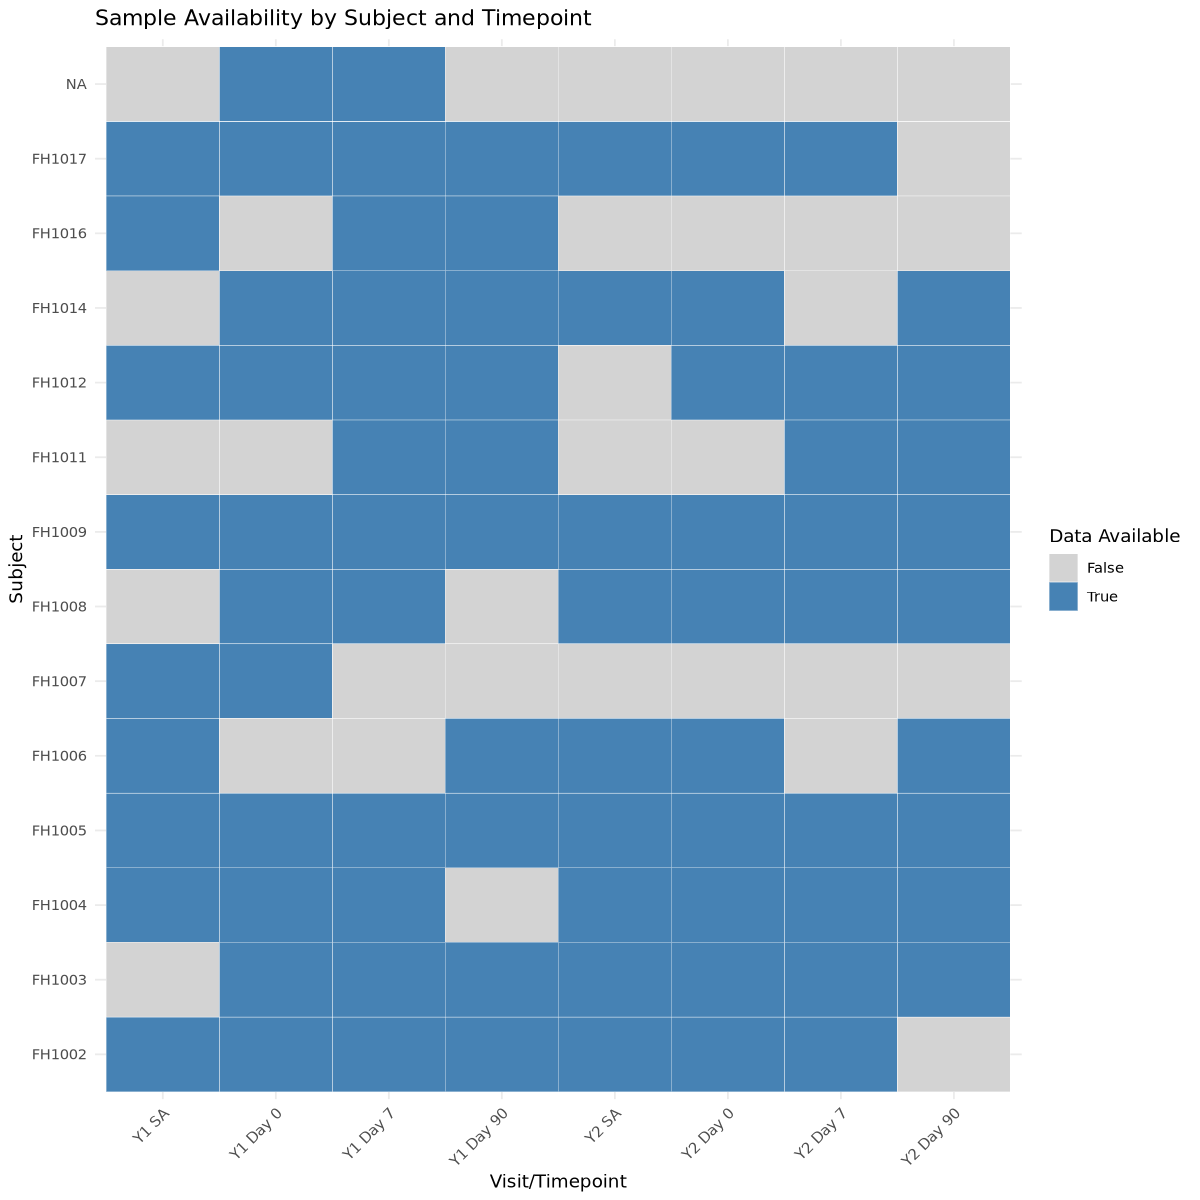

In [3]:
options(repr.plot.width = 10, repr.plot.height = 10)

timepoints_per_subject <- aggregate(visit ~ subject, df, function(x) length(unique(x)))
names(timepoints_per_subject)[2] <- "num_timepoints"

timepoint_data <- unique(df[, c("subject", "visit")])
timepoint_data$present <- 1

all_subjects <- unique(timepoint_data$subject)
all_visits <- unique(timepoint_data$visit)

complete_grid <- expand.grid(subject = all_subjects, visit = all_visits)
plot_data <- merge(complete_grid, timepoint_data, all.x = TRUE)
plot_data$present[is.na(plot_data$present)] <- 0

plot_data$visit <- factor(plot_data$visit, levels = names(timepoint_labels), labels = timepoint_labels)
plot_data$subject <- factor(plot_data$subject, levels = c("FH1002", "FH1003", "FH1004", "FH1005", "FH1006", "FH1007", "FH1008", "FH1009", "FH1011", "FH1012", "FH1014", "FH1016", "FH1017"))

ggplot(plot_data, aes(x = visit, y = subject, fill = factor(present))) +
  geom_tile(color = "white") +
  scale_fill_manual(values = c("0" = "lightgray", "1" = "steelblue"), 
                    labels = c("0" = "False", "1" = "True"),
                    name = "Data Available") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Sample Availability by Subject and Timepoint",
       x = "Visit/Timepoint", y = "Subject")

### All Subject-Visit-Celltype combinations with duplicates

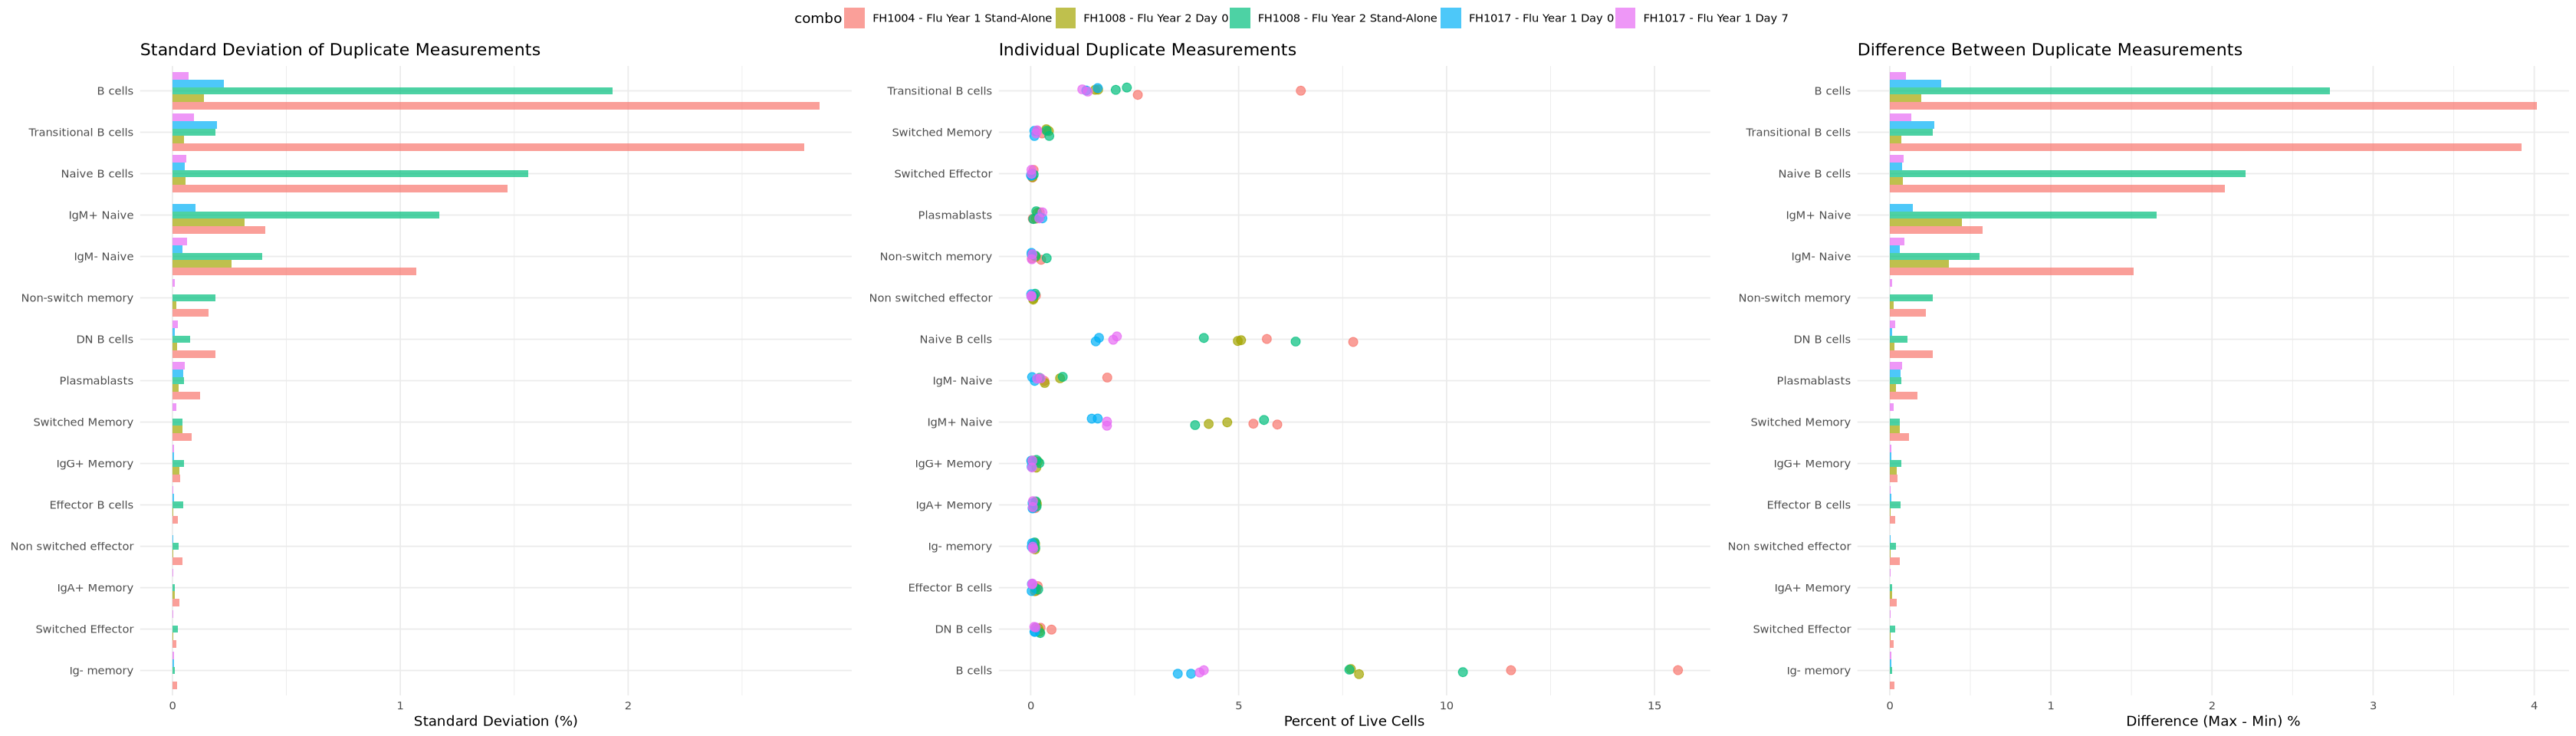

In [4]:
options(repr.plot.width = 28, repr.plot.height = 8)

duplicate_counts <- aggregate(df$percent, 
                            by = list(subject = df$subject, 
                                     visit = df$visit, 
                                     cell = df$cell), 
                            FUN = length)
names(duplicate_counts)[4] <- "N"

duplicates_only <- duplicate_counts[duplicate_counts$N > 1, ]
duplicate_combos <- unique(duplicates_only[, c("subject", "visit")])

duplicate_data <- merge(df, duplicate_combos, by = c("subject", "visit"))
duplicate_data$combo_id <- paste(duplicate_data$subject, duplicate_data$visit, sep = " - ")

duplicate_stats <- aggregate(duplicate_data$percent,
                           by = list(cell = duplicate_data$cell, 
                                   combo = duplicate_data$combo_id),
                           FUN = function(x) c(mean = mean(x), 
                                             sd = sd(x),
                                             min = min(x),
                                             max = max(x),
                                             diff = max(x) - min(x)))

duplicate_stats <- data.frame(
  cell = duplicate_stats$cell,
  combo = duplicate_stats$combo,
  mean_percent = duplicate_stats$x[,"mean"],
  sd_percent = duplicate_stats$x[,"sd"],
  min_percent = duplicate_stats$x[,"min"],
  max_percent = duplicate_stats$x[,"max"],
  diff_percent = duplicate_stats$x[,"diff"]
)

p1 <- ggplot(duplicate_stats, aes(x = reorder(cell, sd_percent), y = sd_percent, fill = combo)) +
  geom_col(position = "dodge", alpha = 0.7) +
  coord_flip() +
  labs(title = "Standard Deviation of Duplicate Measurements",
       x = "",
       y = "Standard Deviation (%)") +
  theme_minimal()

p2 <- ggplot(duplicate_data, aes(x = cell, y = percent, color = combo_id)) +
  geom_point(size = 3, alpha = 0.7, position = position_jitter(width = 0.1)) +
  coord_flip() +
  labs(title = "Individual Duplicate Measurements",
       x = "",
       y = "Percent of Live Cells") +
  theme_minimal()

p3 <- ggplot(duplicate_stats, aes(x = reorder(cell, diff_percent), y = diff_percent, fill = combo)) +
  geom_col(position = "dodge", alpha = 0.7) +
  coord_flip() +
  labs(title = "Difference Between Duplicate Measurements",
       x = "",
       y = "Difference (Max - Min) %") +
  theme_minimal()

plots <- list(p1, p2, p3)

ggpubr::ggarrange(plotlist = plots, common.legend = TRUE, ncol = 3, nrow = 1)

## Plotting

### Plotting year 1 & 2

Warning message in wilcox.test.default(pairwise_data[, 2][[1]], pairwise_data[, :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(pairwise_data[, 2][[1]], pairwise_data[, :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(pairwise_data[, 2][[1]], pairwise_data[, :
“cannot compute exact p-value with zeroes”


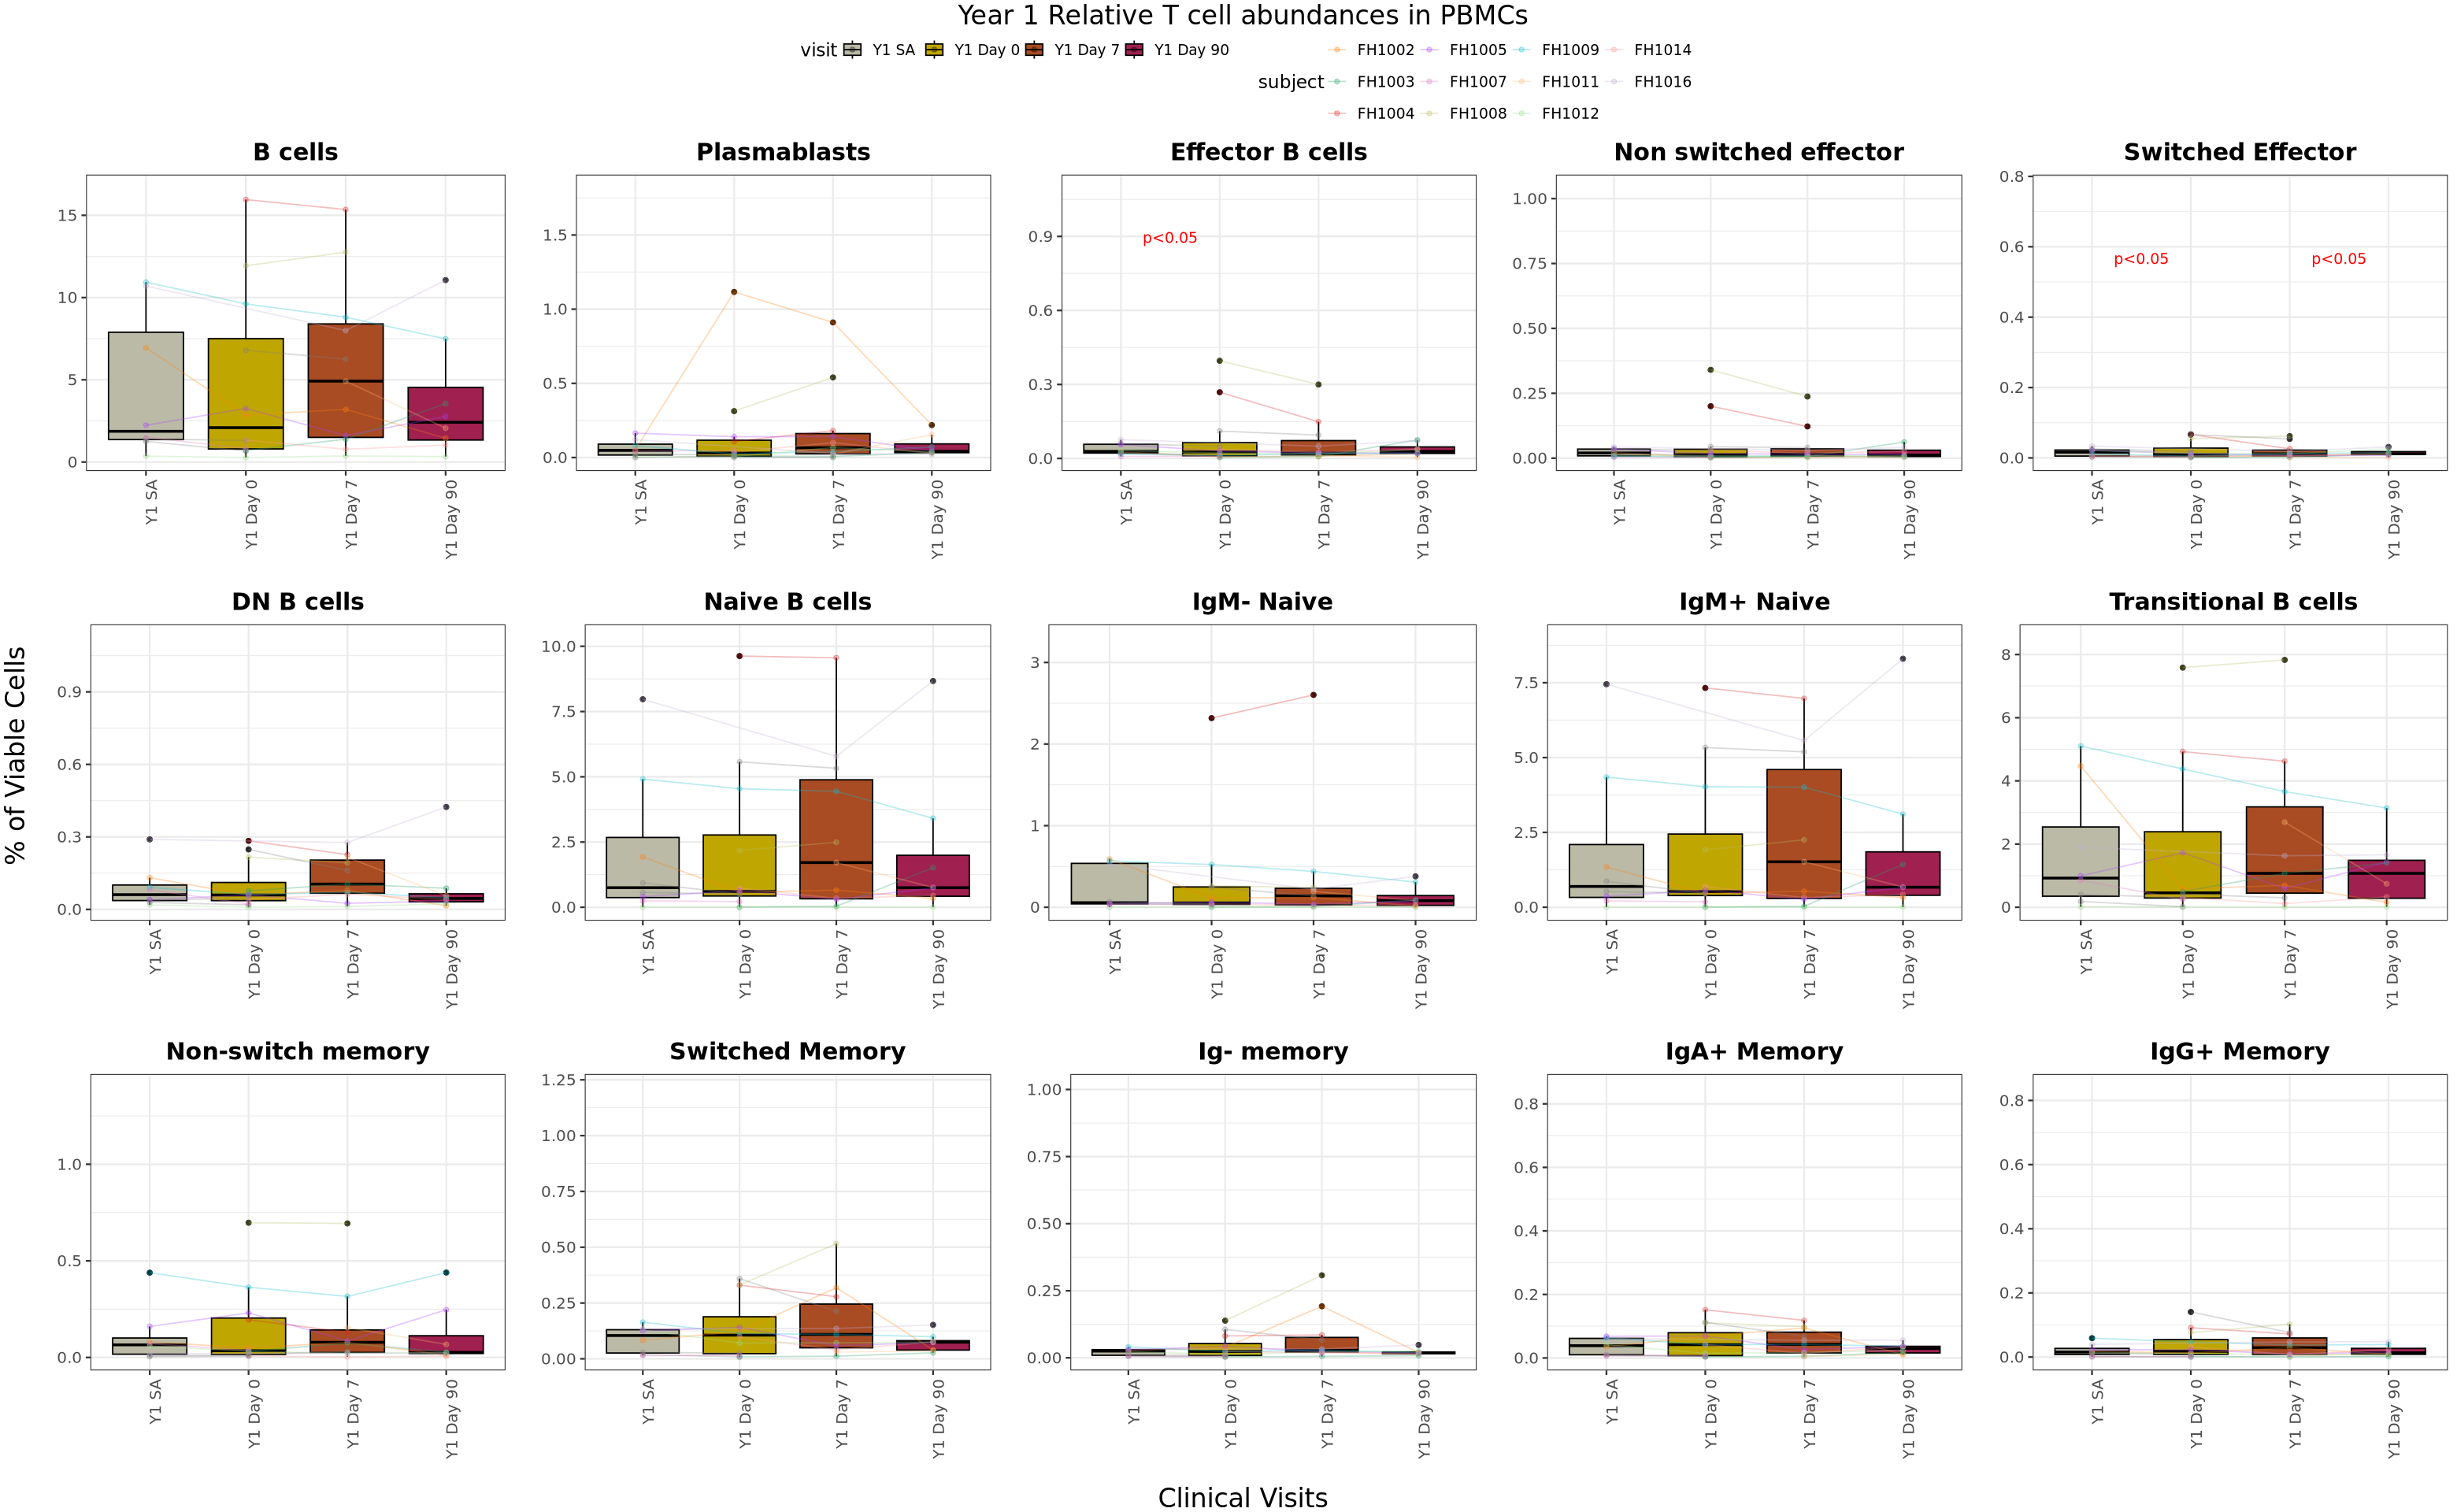

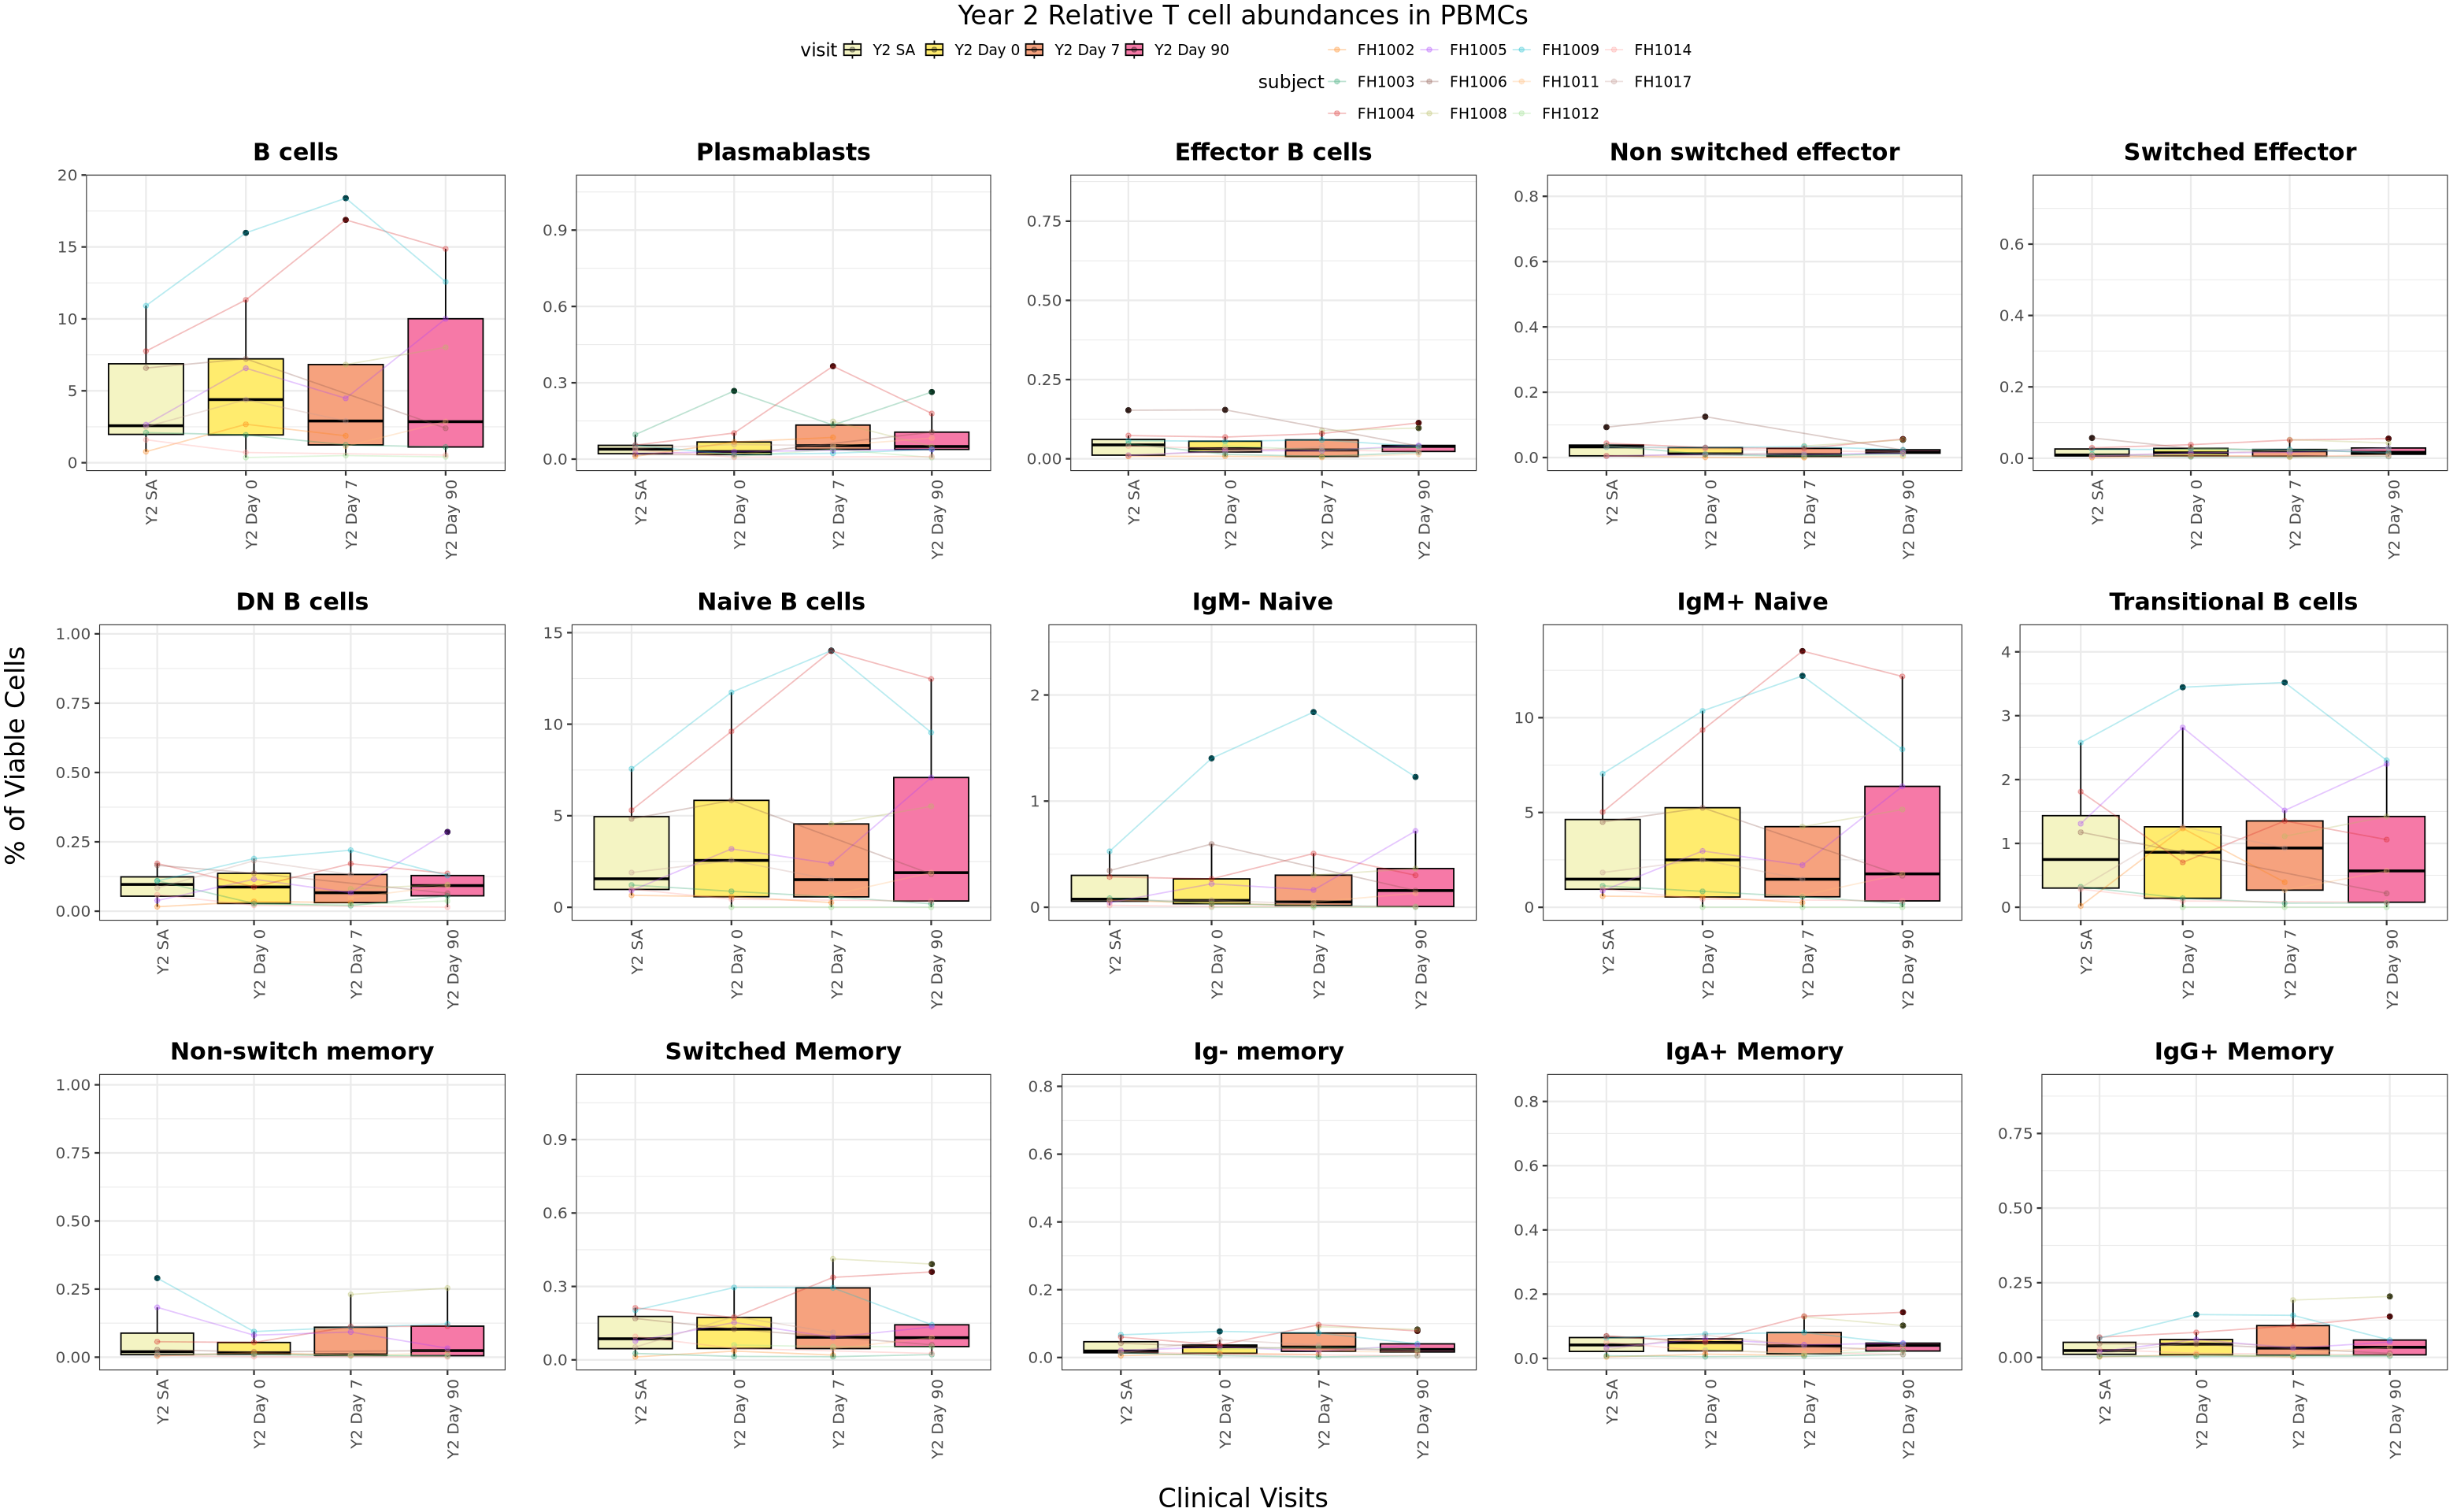

In [6]:
options(repr.plot.width = 26, repr.plot.height = 16)

df$cell_type_frac_total <- df$percent

duplicate_counts <- aggregate(df$cell_type_frac_total, 
                            by = list(subject = df$subject, visit = df$visit, cell = df$cell), 
                            FUN = length)
names(duplicate_counts)[4] <- "N"
duplicate_combos <- unique(duplicate_counts[duplicate_counts$N > 1, c("subject", "visit")])
df <- df[!paste(df$subject, df$visit) %in% paste(duplicate_combos$subject, duplicate_combos$visit), ]

df$visit <- factor(timepoint_labels[df$visit], 
                  levels = c("Y1 SA", "Y1 Day 0", "Y1 Day 7", "Y1 Day 90", 
                            "Y2 SA", "Y2 Day 0", "Y2 Day 7", "Y2 Day 90"))

timepoints_pairs <- list(
    Y1 = list(c('Y1 SA','Y1 Day 0'), c('Y1 Day 0','Y1 Day 7'), c('Y1 Day 7', 'Y1 Day 90')),
    Y2 = list(c('Y2 SA','Y2 Day 0'), c('Y2 Day 0','Y2 Day 7'), c('Y2 Day 7', 'Y2 Day 90'))
)

create_figure <- function(pairs, title) {
    plotlist <- lapply(unique(df$cell), function(x) {
        testCelltype_paired(df, x, pairsOfTimes = pairs, size = 4)$Plot
    })
    fig <- ggpubr::ggarrange(plotlist = plotlist, 
                            common.legend = TRUE, 
                            legend.grob = get_legend(plotlist[[1]]),
                            ncol = 5, nrow = 3)
    fig <- annotate_figure(fig, top = text_grob(title, size = 20))
    annotate_figure(fig, bottom = text_grob('Clinical Visits', size = 20),
                   left = text_grob('% of Viable Cells', size = 20, rot = 90))
}

y1_fig <- create_figure(timepoints_pairs$Y1, 'Year 1 Relative T cell abundances in PBMCs')
y2_fig <- create_figure(timepoints_pairs$Y2, 'Year 2 Relative T cell abundances in PBMCs')

print(y1_fig)
print(y2_fig)